In [1]:
%conda activate qwen

ValueError: The python kernel does not appear to be a conda environment.  Please use ``%pip install`` instead.

In [1]:
import numpy as np
from PIL import Image
import decord
from decord import VideoReader, cpu
import os
import json
import csv
import random
from matplotlib import pyplot as plt
from IPython.display import display, clear_output
import time
import cv2
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

videos_path = "/auto/plzen4-ntis/projects/korpusy_cv/WLASL/WLASL300/val"
json_file_path = "/auto/plzen4-ntis/projects/korpusy_cv/WLASL/WLASL300/WLASL_v0.3.json"

In [2]:
# Load JSON data
print("Loading WLASL JSON data...")
with open(json_file_path, 'r') as f:
    wlasl_data = json.load(f)

print(f"Loaded {len(wlasl_data)} glosses from JSON")

val_videos = []

for gloss_idx, gloss_entry in enumerate(wlasl_data):
    gloss_name = gloss_entry['gloss']
    gloss_folder = str(gloss_idx)  # Folder named by index
    gloss_folder_path = os.path.join(videos_path, gloss_folder)
    
    # Check if this gloss has a test folder
    if not os.path.exists(gloss_folder_path):
        continue
        
    # Get all instances marked as test split
    for instance in gloss_entry['instances']:
        if instance.get('split') == 'val':
            video_id = instance['video_id']
            video_filename = f"{video_id}.mp4"
            video_path = os.path.join(gloss_folder_path, video_filename)
            
            # Check if video file exists
            if os.path.exists(video_path):
                val_videos.append({
                    'video_path': video_path,
                    'ground_truth_gloss': gloss_name,
                    'gloss_id': gloss_idx,
                    'video_id': video_id,
                    'fps': instance.get('fps', 25)  # Use fps from instance, default to 25
                })



# Set random seed for reproducible order
# random.seed(42)
# random.shuffle(test_videos)

Loading WLASL JSON data...


FileNotFoundError: [Errno 2] No such file or directory: '/auto/plzen4-ntis/projects/korpusy_cv/WLASL/WLASL300/WLASL_v0.3.json'

In [4]:
len(wlasl_data)

2000

In [4]:
wlasl_data[0].keys()

dict_keys(['gloss', 'instances'])

In [5]:
wlasl_data[0]['instances'][5]

{'bbox': [110, 25, 274, 240],
 'fps': 25,
 'frame_end': 2249,
 'frame_start': 2150,
 'instance_id': 5,
 'signer_id': 121,
 'source': 'northtexas',
 'split': 'val',
 'url': 'https://www.youtube.com/watch?v=hjS0dQDgbjo',
 'variation_id': 0,
 'video_id': '70212'}

In [5]:
val_videos[0]

{'video_path': '/auto/plzen4-ntis/projects/korpusy_cv/WLASL/WLASL300/val/0/70212.mp4',
 'ground_truth_gloss': 'book',
 'gloss_id': 0,
 'video_id': '70212',
 'fps': 25}

In [18]:
vid_idx = 1
vr = decord.VideoReader(val_videos[vid_idx]['video_path'])
gloss = val_videos[vid_idx]['ground_truth_gloss']
fps = val_videos[vid_idx]['fps']

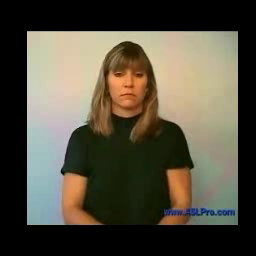

In [8]:
from IPython.display import display, clear_output
import time
for frame in vr:
    img = Image.fromarray(frame.asnumpy())
    clear_output(wait=True)
    display(img)
    time.sleep(1/vr.get_avg_fps())

In [6]:
# def get_equally_distributed_frames(vr, required_fps=None, required_fames=None):
#     if (required_fps is not None and required_fames is not None) or (required_fps is None and required_fames is None):
#         print('Method reqires variable: required_fps xor required_fames')
#         return
#     # vr = decord.VideoReader(test_videos[vid_idx]['video_path'])
#     # gloss = test_videos[vid_idx]['ground_truth_gloss']
#     # fps = test_videos[vid_idx]['fps']
#     frames = [Image.fromarray(frame.asnumpy()) for frame in vr]  # list of PIL images
#     frames = np.stack(frames)
#     if required_fps is not None:
#         required_frames = int(len(frames)/vr.get_avg_fps()*required_fps)
#     reqired_idxs = np.linspace(0, len(frames)-1, required_frames).astype(np.int32)
#     return frames[reqired_idxs]
from data_handlers import get_equally_distributed_frames, energy_fom_flow

In [19]:
frames = [Image.fromarray(frame.asnumpy()) for frame in vr]  # list of PIL images
frames = np.stack(frames)
print(frames.shape)

(92, 480, 640, 3)


In [24]:
plt.imsave('WLASL_12.png', frames[50].astype(np.uint8))

In [10]:
required_fps = 2
equally_distributed_frames = get_equally_distributed_frames(frames, vr.get_avg_fps(), required_fps=required_fps)
equally_distributed_frames.shape

(7, 256, 256, 3)

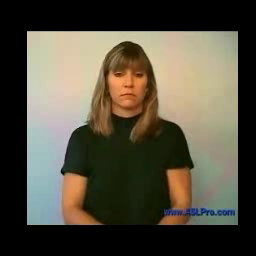

In [11]:
for frame in equally_distributed_frames:
    img = Image.fromarray(frame)
    clear_output(wait=True)
    display(img)
    time.sleep(1/required_fps)

In [13]:
frames.shape

(88, 256, 256, 3)

In [14]:
video_movement = []
for i in range(len(frames)-1):
    video_movement.append(np.sum(np.abs(frames[i]-frames[i+1])))
video_movement_normalized = video_movement/np.linalg.norm(video_movement)

Text(0.5, 1.0, 'pixel difference')

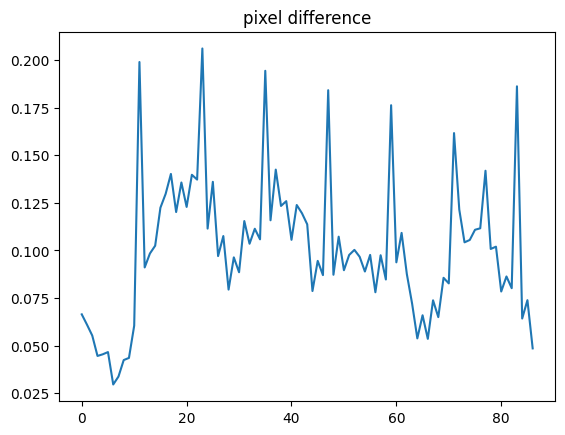

In [15]:
plt.plot(video_movement_normalized)
plt.title('pixel difference')

In [16]:
# def energy_fom_flow(vr):
#     prev_gray = None
#     flow_magnitudes = []
#     kinetic_energy = []
    
#     for i in range(len(vr)):
#         # Convert Decord NDArray -> NumPy uint8
#         frame = vr[i].asnumpy().astype(np.uint8)
#         frame = cv2.resize(frame, (124, 124), interpolation=cv2.INTER_AREA)
        
#         # Convert RGB -> grayscale
#         gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY).astype(np.uint8)
    
#         if prev_gray is not None:
#             # Ensure prev_gray is also uint8 numpy
#             prev_gray = prev_gray.astype(np.uint8)
    
#             # Farnebäck optical flow
#             flow = cv2.calcOpticalFlowFarneback(
#                 prev_gray, gray, None,
#                 pyr_scale=0.5, levels=3, winsize=15,
#                 iterations=3, poly_n=5, poly_sigma=1.2, flags=0
#             )
    
#             # Compute magnitude of flow
#             mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
#             flow_magnitudes.append(np.mean(mag))
    
#             KE = 0.5 * (mag ** 2)
    
#             # Total kinetic energy across frame
#             total_KE = np.sum(KE)
#             kinetic_energy.append(total_KE)
    
#         prev_gray = gray
    
    
#     # flow_magnitudes_normalized = flow_magnitudes/np.linalg.norm(flow_magnitudes)
#     # kinetic_energy_normalized = kinetic_energy/np.linalg.norm(kinetic_energy)
#     return np.array(flow_magnitudes), np.array(kinetic_energy)

In [17]:
flow_magnitudes, kinetic_energy = energy_fom_flow(vr)

Text(0.5, 1.0, 'flow magnitudes')

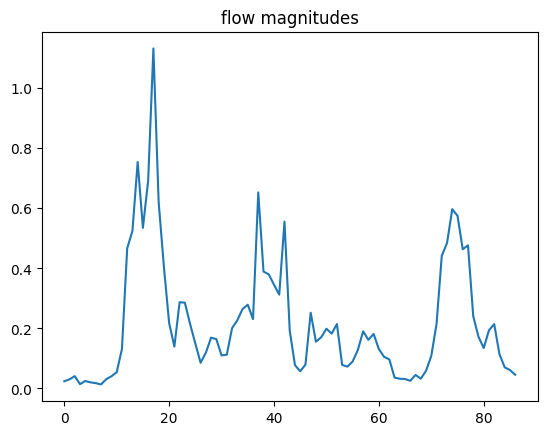

In [18]:
plt.plot(flow_magnitudes)
plt.title('flow magnitudes')

Text(0.5, 1.0, 'flow kinetic energy')

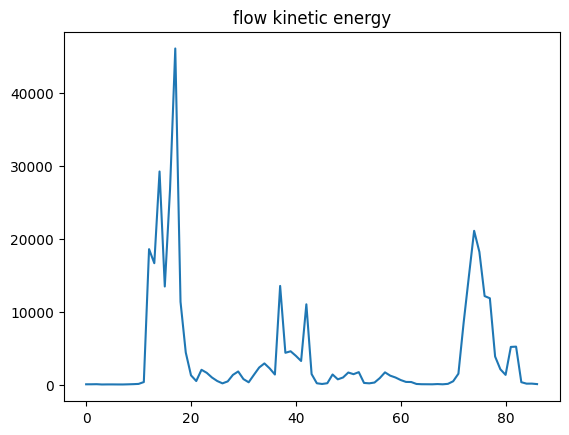

In [19]:
plt.plot(kinetic_energy)
plt.title('flow kinetic energy')

In [20]:
# from scipy.stats import rankdata

def show_movement_graph_alligned(vr, flow_magnitudes, kinetic_energy, gloss=None):
    # flow_magnitudes = flow_magnitudes/np.linalg.norm(flow_magnitudes)
    # kinetic_energy = kinetic_energy/np.linalg.norm(kinetic_energy)

    # flow_magnitudes = flow_magnitudes/flow_magnitudes.mean()
    # kinetic_energy = kinetic_energy/kinetic_energy.mean()
    
    flow_magnitudes = (flow_magnitudes - flow_magnitudes.min()) / (flow_magnitudes.max() - flow_magnitudes.min())
    kinetic_energy = (kinetic_energy - kinetic_energy.min()) / (kinetic_energy.max() - kinetic_energy.min())

    # ranks_mag = rankdata(flow_magnitudes)
    # ranks_kin = rankdata(kinetic_energy)
    # flow_magnitudes = 1 - (ranks_mag - 1) / (len(ranks_mag) - 1)
    # kinetic_energy = 1 - (ranks_kin - 1) / (len(ranks_kin) - 1)
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    for i, frame in enumerate(vr):
        # Convert video frame
        img = Image.fromarray(frame.asnumpy())
    
        # Clear axes
        ax1.clear()
        ax2.clear()
    
        # Show video frame
        ax1.imshow(img)
        # display(img)
        if gloss==None:
            ax1.set_title("Video")
        else:
            ax1.set_title("Video: " + gloss)
        ax1.axis("off")
    
        # Plot movement curve up to current frame
        ax2.plot(flow_magnitudes, label="flow_magnitude")
        ax2.axvline(i, color="r", linestyle="--")  # mark current frame
        ax2.set_title("Movement Curve")
        ax2.legend()
    
        # Plot movement curve up to current frame
        ax2.plot(kinetic_energy, label="kinetic_energy")
        ax2.axvline(i, color="r", linestyle="--")  # mark current frame
        ax2.set_title("Movement Curve")
        ax2.legend()
    
        # Refresh display
        clear_output(wait=True)
        display(fig)
        # time.sleep(1 / vr.get_avg_fps())
    
    plt.close(fig)  # close final figure to prevent duplicate static plot

def show_movement_graph(vr, flow_magnitudes, kinetic_energy, gloss=None):
    # Create figure
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
    
    for i, frame in enumerate(vr):
        # Convert video frame
        img = Image.fromarray(frame.asnumpy())
    
        # Clear axes
        ax1.clear()
        ax2.clear()
        ax3.clear()
    
        # Show video frame
        ax1.imshow(img)
        # display(img)
        if gloss==None:
                ax1.set_title("Video")
        else:
            ax1.set_title("Video: " + gloss)
        ax1.axis("off")
    
        # Plot movement curve up to current frame
        ax2.plot(flow_magnitudes, label="flow_magnitude")
        ax2.axvline(i, color="r", linestyle="--")  # mark current frame
        ax2.set_title("Movement Curve")
        ax2.legend()
    
        # Plot movement curve up to current frame
        ax3.plot(kinetic_energy, label="kinetic_energy")
        ax3.axvline(i, color="r", linestyle="--")  # mark current frame
        ax3.set_title("Movement Curve")
        ax3.legend()
    
        # Refresh display
        clear_output(wait=True)
        display(fig)
        # time.sleep(1 / vr.get_avg_fps())
    
    plt.close(fig)  # close final figure to prevent duplicate static plot

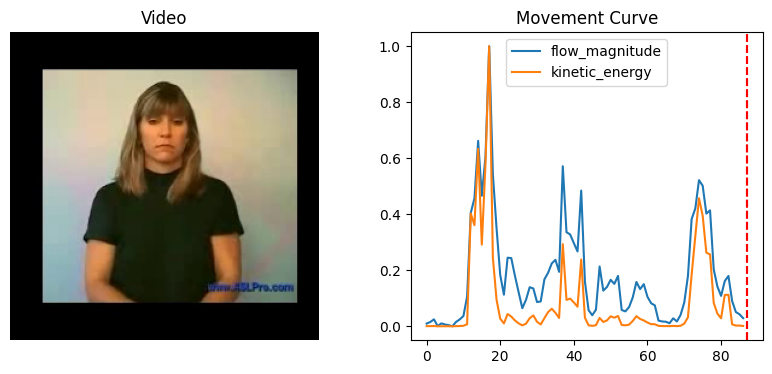

In [21]:
show_movement_graph_alligned(vr, flow_magnitudes, kinetic_energy)

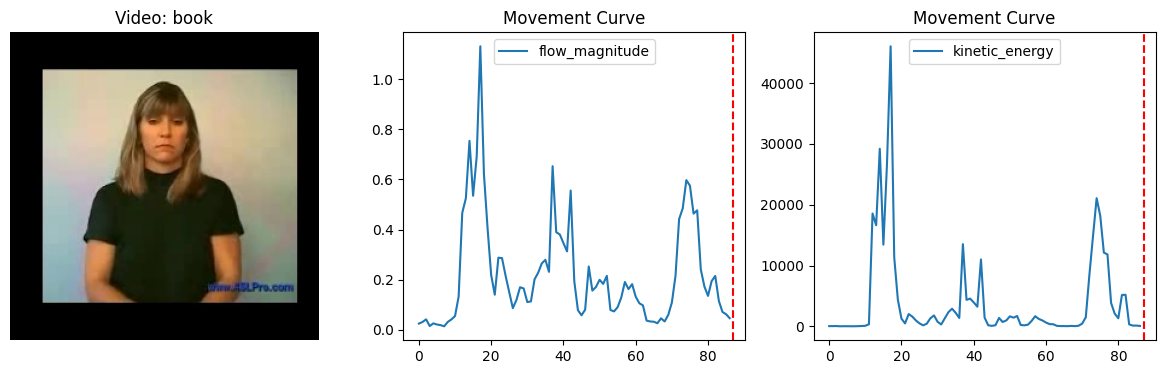

In [22]:
show_movement_graph(vr, flow_magnitudes, kinetic_energy, gloss=gloss)

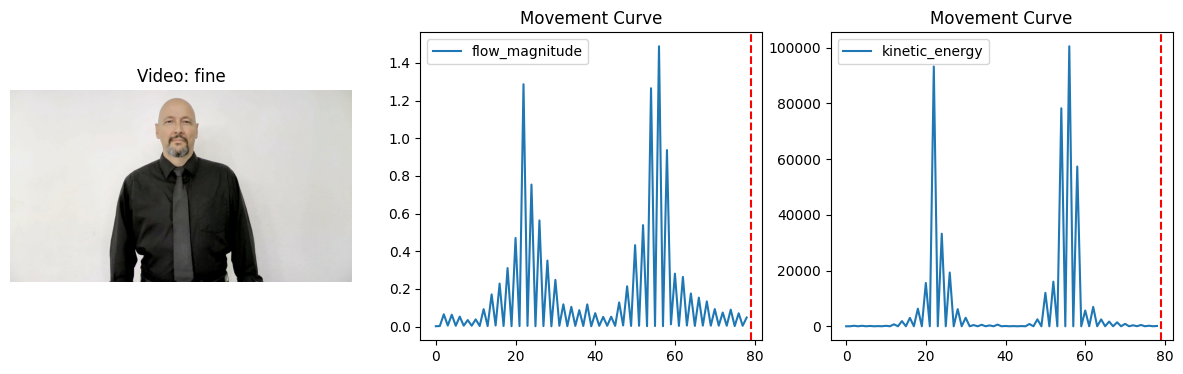

In [23]:
video_idx = 50
gloss = val_videos[video_idx]['ground_truth_gloss']
vr = decord.VideoReader(val_videos[video_idx]['video_path'])
flow_magnitudes50, kinetic_energy50 = energy_fom_flow(vr)
show_movement_graph(vr, flow_magnitudes50, kinetic_energy50, gloss=gloss)

In [24]:
video_idx = 0
gloss = val_videos[video_idx]['ground_truth_gloss']
vr = decord.VideoReader(val_videos[video_idx]['video_path'])
flow_magnitudes, kinetic_energy = energy_fom_flow(vr)
# show_movement_graph(vr, flow_magnitudes, kinetic_energy, gloss=gloss)
# show_movement_graph_alligned(vr, flow_magnitudes, kinetic_energy, gloss=gloss)

In [51]:
video_idx = 1
gloss = val_videos[video_idx]['ground_truth_gloss']
vr = decord.VideoReader(val_videos[video_idx]['video_path'])
flow_magnitudes, kinetic_energy = energy_fom_flow(vr)
smoothed = gaussian_filter1d(flow_magnitudes, sigma=3)

Text(0.5, 1.0, 'smoothed')

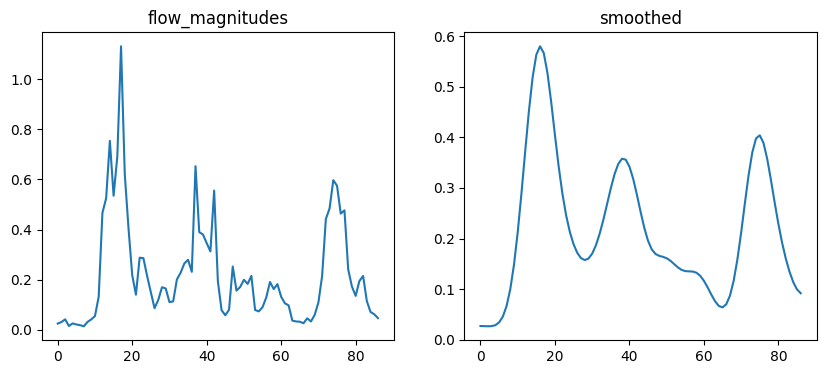

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(flow_magnitudes)
ax1.set_title("flow_magnitudes")
ax2.plot(smoothed)
ax2.set_title("smoothed")

In [27]:
peaks, properties = find_peaks(smoothed, distance=2, prominence=0.1)
peaks

array([12, 39, 67])

Text(0.5, 1.0, 'smoothed')

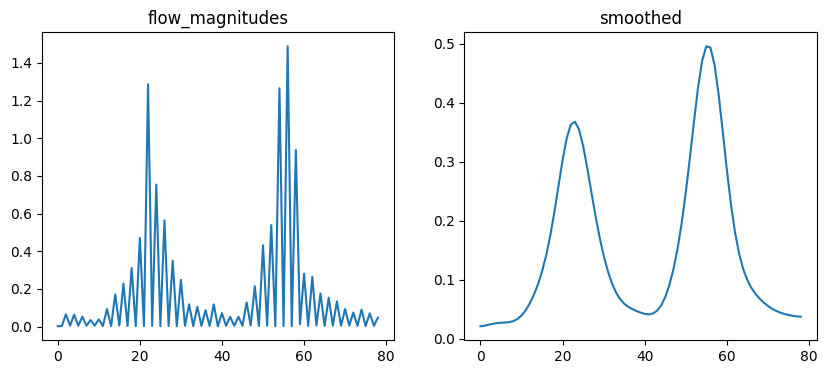

In [28]:
smoothed50 = gaussian_filter1d(flow_magnitudes50, sigma=3)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(flow_magnitudes50)
ax1.set_title("flow_magnitudes")
ax2.plot(smoothed50)
ax2.set_title("smoothed")

In [29]:
peaks, properties = find_peaks(smoothed50, distance=2, prominence=0.1)
peaks

array([23, 55])

In [30]:
def get_adaptive_frames(vr, max_peak_valley_dist=0.5):
    frames = [Image.fromarray(frame.asnumpy()) for frame in vr]  # list of PIL images
    frames = np.stack(frames)
    flow_magnitudes, kinetic_energy = energy_fom_flow(vr)
    smoothed = gaussian_filter1d(flow_magnitudes, sigma=3)
    peaks, properties = find_peaks(smoothed, distance=2, prominence=0.1)
    if len(peaks)<2:
        # frames = get_equally_distributed_frames(vr, required_fps=required_fps, required_fames=None)
        return frames
    # elif len(peaks)>2:
    #     top_two_indices = peaks[np.argsort(flow_magnitudes[peaks])[-2:]]
    #     top_two_indices.sort()
    #     peaks = top_two_indices
    if len(peaks)>=2:
        valleys, properties = find_peaks(-smoothed, distance=2, prominence=0.001)
        mask = (peaks[0] < valleys) & (valleys < peaks[1])
        valleys = valleys[mask]
        if len(valleys) >= 2:
            #valley needs to be close to peak
            if min(valleys)-min(peaks) < vr.get_avg_fps()*max_peak_valley_dist:
                low_bound = int((min(valleys)+min(peaks))/2)
            else:
                low_bound = min(peaks)
            if max(peaks)-max(valleys) < vr.get_avg_fps()*max_peak_valley_dist:
                high_bound = int((max(valleys)+max(peaks))/2)
            else:
                high_bound = max(peaks)
        elif len(valleys) == 1:
            if max(peaks)-valleys[0] < vr.get_avg_fps()*max_peak_valley_dist:
                high_bound = int((max(valleys)+max(peaks))/2)
                low_bound = min(peaks)
            elif valleys[0]-min(peaks) < vr.get_avg_fps()*max_peak_valley_dist:
                low_bound = int((min(valleys)+min(peaks))/2)
                high_bound = max(peaks)
            else:
                low_bound = min(peaks)
                high_bound = max(peaks)
        else:
            low_bound = min(peaks)
            high_bound = max(peaks)
        print(low_bound)
        print(high_bound)
        if low_bound < len(frames)/2 and high_bound > len(frames)/2:
            frames = frames[low_bound:high_bound]
    return frames

In [31]:
valleys = np.array([15, 30, 60])
min(valleys)

15

In [32]:
MAX_WIDTH, MAX_HEIGHT = 640, 480  

def resize_to_max(img: Image.Image, max_w=MAX_WIDTH, max_h=MAX_HEIGHT) -> Image.Image:
    """Resize an image so that neither dimension exceeds max_w/max_h,
    while preserving aspect ratio."""
    w, h = img.size
    if w > max_w or h > max_h:
        img.thumbnail((max_w, max_h), Image.LANCZOS)  # in-place resize
    return img

In [154]:
import importlib
import data_handlers
importlib.reload(data_handlers)
from data_handlers import get_adaptive_frames, get_equally_distributed_frames

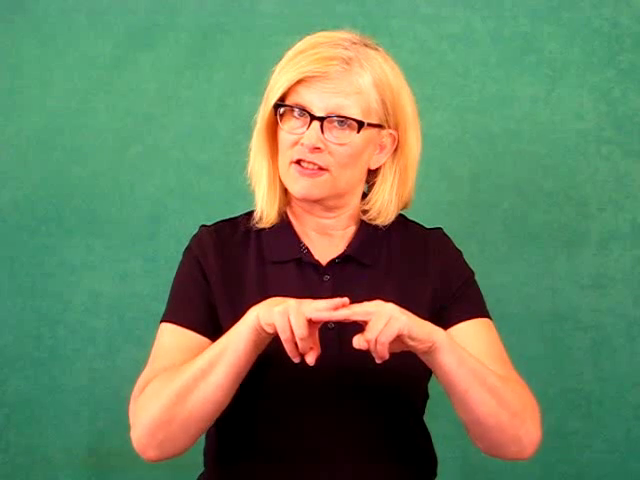

'gloss: chair'

In [155]:
video_idx = 21
fps=10
gloss = val_videos[video_idx]['ground_truth_gloss']
vr = decord.VideoReader(val_videos[video_idx]['video_path'])
# fps=vr.get_avg_fps()
adaptive_frames = get_adaptive_frames(vr, required_fps=fps)
for frame in adaptive_frames:
    img = Image.fromarray(frame)
    img = resize_to_max(img)
    clear_output(wait=True)
    display(img, f"gloss: {gloss}")
    # display(img)
    time.sleep(1/fps)

In [153]:
adaptive_frames.shape

(6, 480, 640, 3)

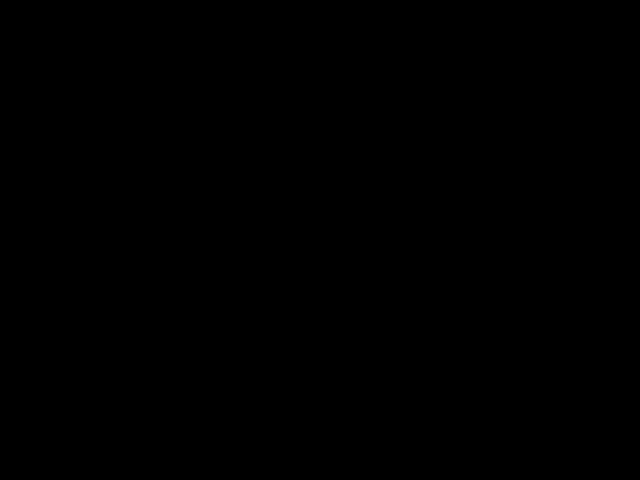

'gloss: chair'

In [145]:
for frame in vr:
    img = Image.fromarray(frame.asnumpy())
    img = resize_to_max(img)
    clear_output(wait=True)
    display(img, f"gloss: {gloss}")
    # display(img)
    time.sleep(1/vr.get_avg_fps())

Text(0.5, 1.0, 'smoothed')

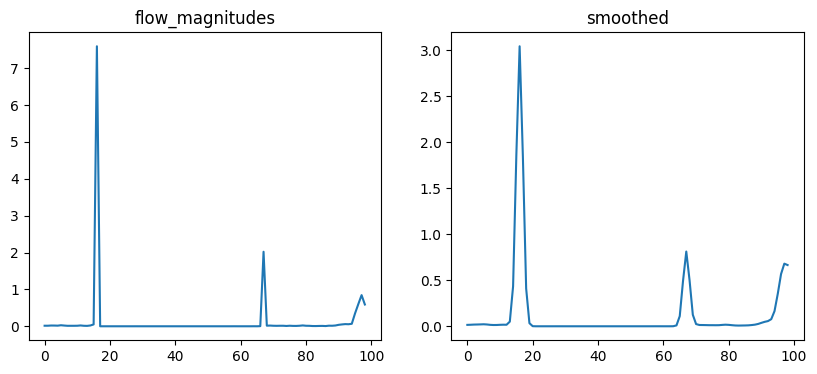

In [120]:
# video_idx = 25
# vr = decord.VideoReader(test_videos[video_idx]['video_path'])
flow_magnitudes, kinetic_energy = energy_fom_flow(vr)
smoothed = gaussian_filter1d(flow_magnitudes, sigma=1)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.plot(flow_magnitudes)
ax1.set_title("flow_magnitudes")
ax2.plot(smoothed)
ax2.set_title("smoothed")

In [121]:
peaks, _ =find_peaks(smoothed, distance=2, prominence=0.1)
peaks

array([16, 67])

In [37]:
vr.get_avg_fps()/2

15.001630612023046

## poznatky
Video 3 si na klid změní pozadí a to to celý rozhodí.

Některý videa jako 0, 7 tam hází černou obrazovku s textem, což je hodně veliká změna...

Video 8 ukazuje ten znak dvakrát :)

U videa 21 je vidět rozdíl mezi 10 a 15 fps

